In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the data to [0, 1] range
x_train = x_train / 255.0
x_test = x_test / 255.0


# Split the training data into training and validation sets
validation_split = 0.2
val_samples = int(len(x_train) * validation_split)
x_val = x_train[:val_samples]
y_val = y_train[:val_samples]
x_train = x_train[val_samples:]
y_train = y_train[val_samples:]



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [2]:
# Define the EfficientNetB2 model without pretrained weights
def build_efficientnet_model(input_shape=(32, 32, 3), num_classes=10):
    # Input layer
    inputs = Input(shape=input_shape)

    # EfficientNetB2 backbone without pretrained weights
    base_model = EfficientNetB2(include_top=False, weights=None, input_tensor=inputs)

    # Add global average pooling
    x = GlobalAveragePooling2D()(base_model.output)

    # Add a dense classification head
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs, outputs)
    return model

# Build the model
model = build_efficientnet_model()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Directory to save the best model
save_dir = "./efficientnet_checkpoints"
os.makedirs(save_dir, exist_ok=True)

# Callbacks: Save best model and early stopping
checkpoint = ModelCheckpoint(
    filepath=os.path.join(save_dir, "best_model.keras"),
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="max",
    verbose=1
)


In [3]:

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1696 - loss: 2.3657
Epoch 1: val_accuracy improved from -inf to 0.11370, saving model to ./efficientnet_checkpoints/best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 71ms/step - accuracy: 0.1697 - loss: 2.3654 - val_accuracy: 0.1137 - val_loss: 2.4822
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2980 - loss: 1.9456
Epoch 2: val_accuracy improved from 0.11370 to 0.29240, saving model to ./efficientnet_checkpoints/best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - accuracy: 0.2980 - loss: 1.9455 - val_accuracy: 0.2924 - val_loss: 1.9995
Epoch 3/50
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3559 - loss: 1.7771
Epoch 3: val_accuracy improved from 0.29240 to 0.32560, saving model to ./efficientnet_checkpoints/best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.3559 - loss: 1.7770 - val_accuracy: 0.3256 - val_loss: 2.5123
Epoch 4/50
624/625 ━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6911 - loss: 1.1003
Test Accuracy: 0.69


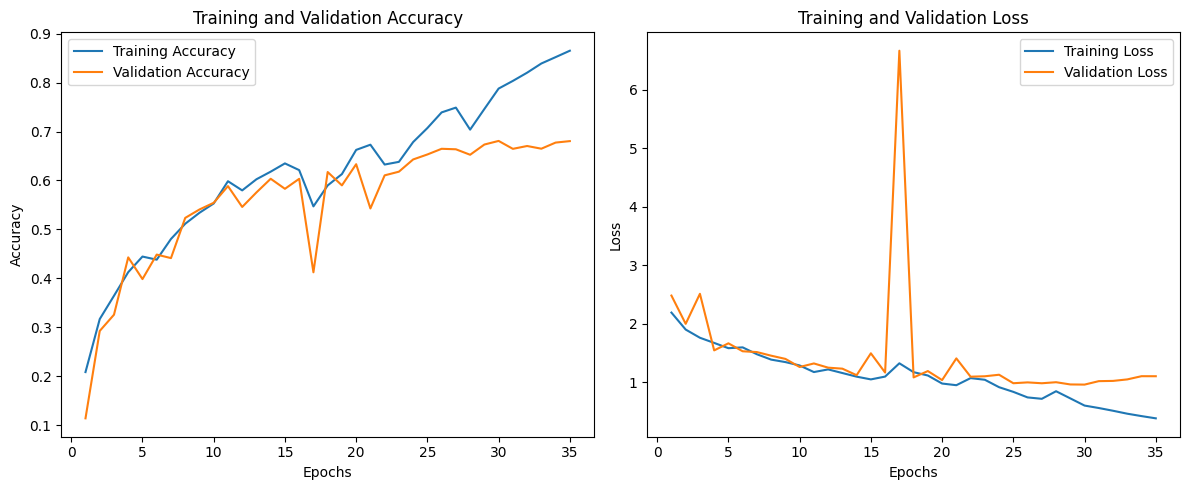

In [5]:

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Load the best model for testing
best_model = tf.keras.models.load_model(os.path.join(save_dir, "best_model.keras"))

# Plot training and validation accuracy and loss
def plot_metrics(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_metrics(history)
